In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
import time
from sklearn.linear_model import LinearRegression
import gc
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.linear_model import LinearRegression

# import datatable as dt

# from pyspark.ml.regression import LinearRegression,RandomForestRegressor

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
building_meta=pd.read_csv('/kaggle/input/ashrae-energy-prediction/building_metadata.csv')
weather_tr=pd.read_csv('/kaggle/input/ashrae-energy-prediction/weather_train.csv')                         
test=pd.read_csv('/kaggle/input/ashrae-energy-prediction/test.csv')
train=pd.read_csv('/kaggle/input/ashrae-energy-prediction/train.csv')
weather_tst=pd.read_csv('/kaggle/input/ashrae-energy-prediction/weather_test.csv')

In [3]:
## Memory optimization

# Original code from https://www.kaggle.com/gemartin/load-data-reduce-memory-usage by @gemartin
# Modified to support timestamp type, categorical type
# Modified to add option to use float16

from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def reduce_mem_usage(df, use_float16=False):
    """
    Iterate through all the columns of a dataframe and modify the data type to reduce memory usage.        
    """
    
    start_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype("category")

    end_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [4]:
train=reduce_mem_usage(train,use_float16=True)
weather_tr=reduce_mem_usage(weather_tr,use_float16=True)
building_meta=reduce_mem_usage(building_meta,use_float16=True)

Memory usage of dataframe is 616.95 MB
Memory usage after optimization is: 173.90 MB
Decreased by 71.8%
Memory usage of dataframe is 9.60 MB
Memory usage after optimization is: 2.65 MB
Decreased by 72.4%
Memory usage of dataframe is 0.07 MB
Memory usage after optimization is: 0.02 MB
Decreased by 73.8%


In [5]:
train.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
1,1,0,2016-01-01 00:00:00,0.0
2,2,0,2016-01-01 00:00:00,0.0
3,3,0,2016-01-01 00:00:00,0.0
4,4,0,2016-01-01 00:00:00,0.0


 ### Prepare data
 join with 2 df buiding and weather both datasets train and test

In [6]:

def prepare_date(X,building,waether,test=False):
    X=X.merge(building,on='building_id',how='left')
    X=X.merge(waether,on=['site_id','timestamp'],how='left')
    X.timestamp=pd.to_datetime(X.timestamp,format='%Y-%m-%d %H:%M:%S')
    X.square_feet=np.log1p(X.square_feet)
    
    if not test:
        X.sort_values('timestamp',inplace=True)
        X.reset_index(drop=True , inplace=True)
        
    holidays = ["2016-01-01", "2016-01-18", "2016-02-15", "2016-05-30", "2016-07-04",
                "2016-09-05", "2016-10-10", "2016-11-11", "2016-11-24", "2016-12-26",
                "2017-01-01", "2017-01-16", "2017-02-20", "2017-05-29", "2017-07-04",
                "2017-09-04", "2017-10-09", "2017-11-10", "2017-11-23", "2017-12-25",
                "2018-01-01", "2018-01-15", "2018-02-19", "2018-05-28", "2018-07-04",
                "2018-09-03", "2018-10-08", "2018-11-12", "2018-11-22", "2018-12-25",
                "2019-01-01"]
    
    X['hour']=X.timestamp.dt.hour
    X['weekday']=X.timestamp.dt.weekday
    X['is_holiday']=(X.timestamp.dt.date.astype("str").isin(holidays)).astype(int)
    
    drop_features = ["timestamp", "sea_level_pressure", "wind_direction", "wind_speed"]

    X.drop(drop_features, axis=1, inplace=True)
    
    if test:
        row_ids=X.row_id
        X.drop('row_id',inplace=True,axis=1)
        return X,row_ids
        
    else:
        y=np.log1p(X.meter_reading)
        X.drop('meter_reading',inplace=True,axis=1)
        
        return X,y

In [7]:
X_train,y_train = prepare_date(train,building_meta,weather_tr)
del train,weather_tr
gc.collect()

73

#### create a two half dataset based on time and use as train and validation vise versa
![](http://)

In [8]:
X_half_1=X_train[:int(X_train.shape[0]/2)]
X_half_2=X_train[int(X_train.shape[0]/2):]

y_half_1=y_train[:int(y_train.shape[0]/2)]
y_half_2=y_train[int(y_train.shape[0]/2):]


categorical_features=["building_id", 'meter', 'site_id', 'primary_use','hour', 'weekday']
d_half_1=lgb.Dataset(X_half_1,label = y_half_1,categorical_feature=categorical_features ,
                    free_raw_data=False)
d_half_2=lgb.Dataset(X_half_2,label = y_half_2,categorical_feature=categorical_features ,
                    free_raw_data=False)


watchlist_1 = [d_half_1,d_half_2]
watchlist_2 = [d_half_2,d_half_1]

params={"objective":"regression",
        "boosting":"gbdt",
        "num_leaves":40 ,
        "learning_rate":0.05 ,
        "feature_fraction":0.85,
        "reg_lambda":2,
        "metric":"rmse"  
        }

print("Building model on the first half and validation on the second half")
model_half_1 = lgb.train(params, d_half_1, num_boost_round=1000, valid_sets=watchlist_1 ,
                        verbose_eval=200,early_stopping_rounds=200)

print("Building model on the second half and validation on the first half")
model_half_2 = lgb.train(params, d_half_2, num_boost_round=1000, valid_sets=watchlist_2 ,
                        verbose_eval=200,early_stopping_rounds=200)

Building model on the first half and validation on the second half


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds
[200]	training's rmse: 0.921699	valid_1's rmse: 1.33749
[400]	training's rmse: 0.868818	valid_1's rmse: 1.33291
Early stopping, best iteration is:
[320]	training's rmse: 0.882908	valid_1's rmse: 1.33134
Building model on the second half and validation on the first half
Training until validation scores don't improve for 200 rounds
[200]	training's rmse: 0.90602	valid_1's rmse: 1.50684
[400]	training's rmse: 0.860636	valid_1's rmse: 1.50278
[600]	training's rmse: 0.835886	valid_1's rmse: 1.50042
[800]	training's rmse: 0.819647	valid_1's rmse: 1.50034
Early stopping, best iteration is:
[664]	training's rmse: 0.830981	valid_1's rmse: 1.49966


**** Feature Importance plot

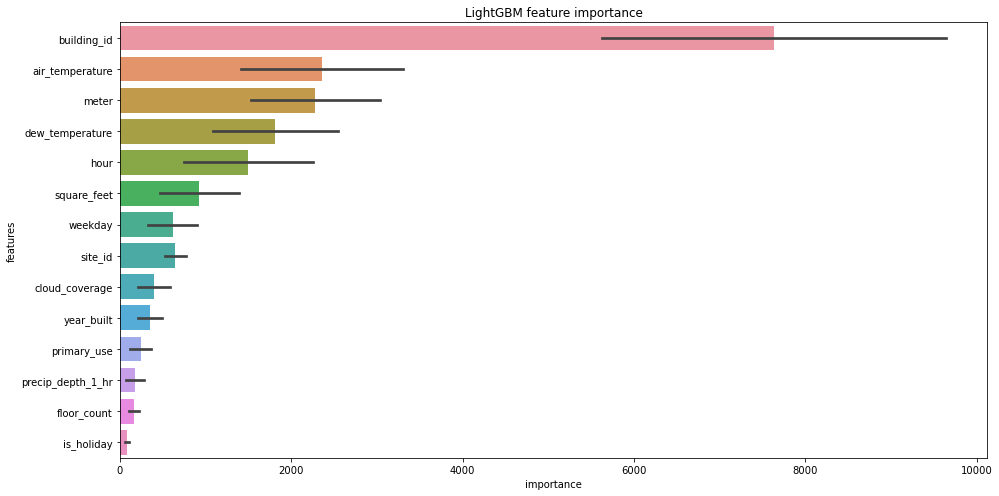

In [9]:
df_fm_1=pd.DataFrame()
df_fm_1['features']=X_train.columns.values
df_fm_1['importance']=model_half_1.feature_importance()
df_fm_1['half'] = 1

df_fm_2=pd.DataFrame()
df_fm_2['features']=X_train.columns.values
df_fm_2['importance']=model_half_2.feature_importance()
df_fm_2['half'] = 2

df_fm = pd.concat([df_fm_1,df_fm_2],axis=0)


plt.figure(figsize=(14,7))
sns.barplot(x='importance' , y='features' ,data=df_fm.sort_values(by='importance' , ascending = False))
plt.title('LightGBM feature importance')
plt.tight_layout()
plt.show()

In [10]:
del X_half_1,X_half_2,X_train,d_half_1,d_half_2,df_fm,df_fm_1,df_fm_2,watchlist_1,watchlist_2,y_half_1,y_half_2,y_train
gc.collect()

4622

In [11]:
df_test = reduce_mem_usage(test)
df_weather = reduce_mem_usage(weather_tst)

X_test ,row_ids = prepare_date(df_test,building_meta , df_weather, test=True)


Memory usage of dataframe is 1272.51 MB
Memory usage after optimization is: 358.65 MB
Decreased by 71.8%
Memory usage of dataframe is 19.04 MB
Memory usage after optimization is: 8.96 MB
Decreased by 53.0%


In [12]:
pred= np.expm1(model_half_1.predict(X_test , num_iteration=model_half_1.best_iteration))/ 2
    
del model_half_1
gc.collect()

56

In [13]:
pred += np.expm1(model_half_2.predict(X_test , num_iteration=model_half_2.best_iteration))/ 2
    
del model_half_2
gc.collect()

24

In [16]:
submission = pd.DataFrame({"row_id":row_ids , "meter_reading":np.clip(pred,0,a_max=None)})
submission.to_csv('submission.csv' , index=False)

## Naive Model

In [ ]:
whos

In [ ]:
from sklearn import preprocessing
OHE = preprocessing.OneHotEncoder()

In [ ]:

# cat_cals=['meter','primary_use','site_id']
# X=train[:,'square_feet']
# for cat in cat_cals:
#     X[:,cat]=np.array(OHE.fit(train[:,cat]))

# X.head()

In [ ]:
train.names

In [ ]:
model = LinearRegression()
model.fit(train[:,["meter", "site_id","square_feet"]], np.log1p(train[:,"meter_reading"]))
model.coef_

In [ ]:
test.head()

In [ ]:
test=test[:,:,dt.join(sample_meta_buliding)]
test.head()

In [ ]:
preds=model.predict(test[:,["meter", "site_id","square_feet"]])

In [ ]:
preds=[max(0,float(x)) for x in preds]
preds

In [ ]:
sample_output=pd.DataFrame(preds,columns=['meter_reading'])
sample_output=sample_output.reset_index()
sample_output=sample_output.rename(columns={'index':'row_id'})
sample_output.to_csv('sample_submission.csv',index=False)

sample_output.head()

In [ ]:
sample_output.columns